In [1]:
from s04utils.modules.load.Timestamps import Timestamps
from s04utils.modules.load.BinnedTimestamps import BinnedTimestamps
from s04utils.modules.analyze import HMM_analysis as hmma

from bokeh.plotting import figure, show, output_notebook, curdoc
from matplotlib_inline.backend_inline import set_matplotlib_formats

import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import os
import glob


from sfHMM import sfHMM1
from sfHMM.gmm import GMMs


In [2]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

Loading BokehJS ...

In [3]:
SOURCE_PATH = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/10uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_10uW_77K_circpol_031.h5'

In [4]:
# Load timestamps from file
ts_binned = BinnedTimestamps(path=SOURCE_PATH, bin_width=0.001)

In [5]:
hmma.create_bokeh_plot(ts_binned)

In [6]:
cutoff_pos, viterbi_steps = hmma.find_last_steps(ts_binned)
print(hmma.find_cutoffset(viterbi_steps))

Detector: detector_0
Unique: [ 3.22794521 19.26013478]
Counts: [31260  2115]

Detector: detector_0
Unique: [0. 1.]
Counts: [31260  2115]

---------------------------------
Detector: detector_1
Unique: [2.26290756 3.08045782]
Counts: [51937 23499]

Detector: detector_1
Unique: [0. 1.]
Counts: [51937 23499]

---------------------------------
Detector: detector_sum
Unique: [ 5.72813335 24.19913526]
Counts: [33780  1771]

Detector: detector_sum
Unique: [0. 1.]
Counts: [33780  1771]

---------------------------------
{'detector_0': 10, 'detector_1': 10, 'detector_sum': 10}


In [7]:
# Iterate over detectors in binned timestamps
for detector in ts_binned.as_dataframe.columns:
    gmms = GMMs(ts_binned.as_dataframe[detector][0:cutoff_pos[detector]], krange=(2, 6))
    gmms.fit()
    #gmms.show_aic_bic()
    #gmms.plot_all()
    gmms_opt_n = gmms.get_optimal(criterion="bic").n_components
    sf = sfHMM1(ts_binned.as_dataframe[detector][0:cutoff_pos[detector]], krange=(2, gmms_opt_n), model='p', name=detector).run_all(plot=False)
    hmma.plot_viterbi(ts_binned, sf)

In [8]:
# Get dwell times
dwell_times = hmma.get_dwell_times(sf)

print(dwell_times)

{6.745417380909793: array([   13,    16,    23,    44,     3,     4,    22,    19,    22,
           8,     7,     6,     9,     5,    14,    25,    15,     7,
           4,     9,     9,     4,     8,     5,     4,     7,    21,
          20,    39,     3,     7,     8,   211,   586,  2096,  2007,
         460,   596,   107,  1523,   245,   369,   506,   323,    26,
           9,    22,   949,    10,   222,  2820,     5,     9,     4,
          90,     9,     5,     5, 20688]), 31.211816205243174: array([  5,   6,   7,   0,   8,  18,   3,  57,   1,   1,   0,   2,   1,
         2,   1,   1,  11,   5,   5,   1, 429,   8,   6,   3,   0,   1,
         9,   3,   0,   4,  89,   8,   0,   5,   0,   4,   6,   8,   1,
         2,   2,   2,   0,   1,   4,   4,   2,   2,   0,   0,   1,   1,
         1,   6, 331,  36,   6,   2])}


In [9]:
# Rename keys in dwell times
print(dwell_times.keys())
first_key = list(dwell_times.keys())[0]
second_key = list(dwell_times.keys())[1]

dwell_times['off'] = dwell_times.pop(first_key)
dwell_times['on'] = dwell_times.pop(second_key)

print(dwell_times.keys())

print(dwell_times['off'])

dict_keys([6.745417380909793, 31.211816205243174])
dict_keys(['off', 'on'])
[   13    16    23    44     3     4    22    19    22     8     7     6
     9     5    14    25    15     7     4     9     9     4     8     5
     4     7    21    20    39     3     7     8   211   586  2096  2007
   460   596   107  1523   245   369   506   323    26     9    22   949
    10   222  2820     5     9     4    90     9     5     5 20688]


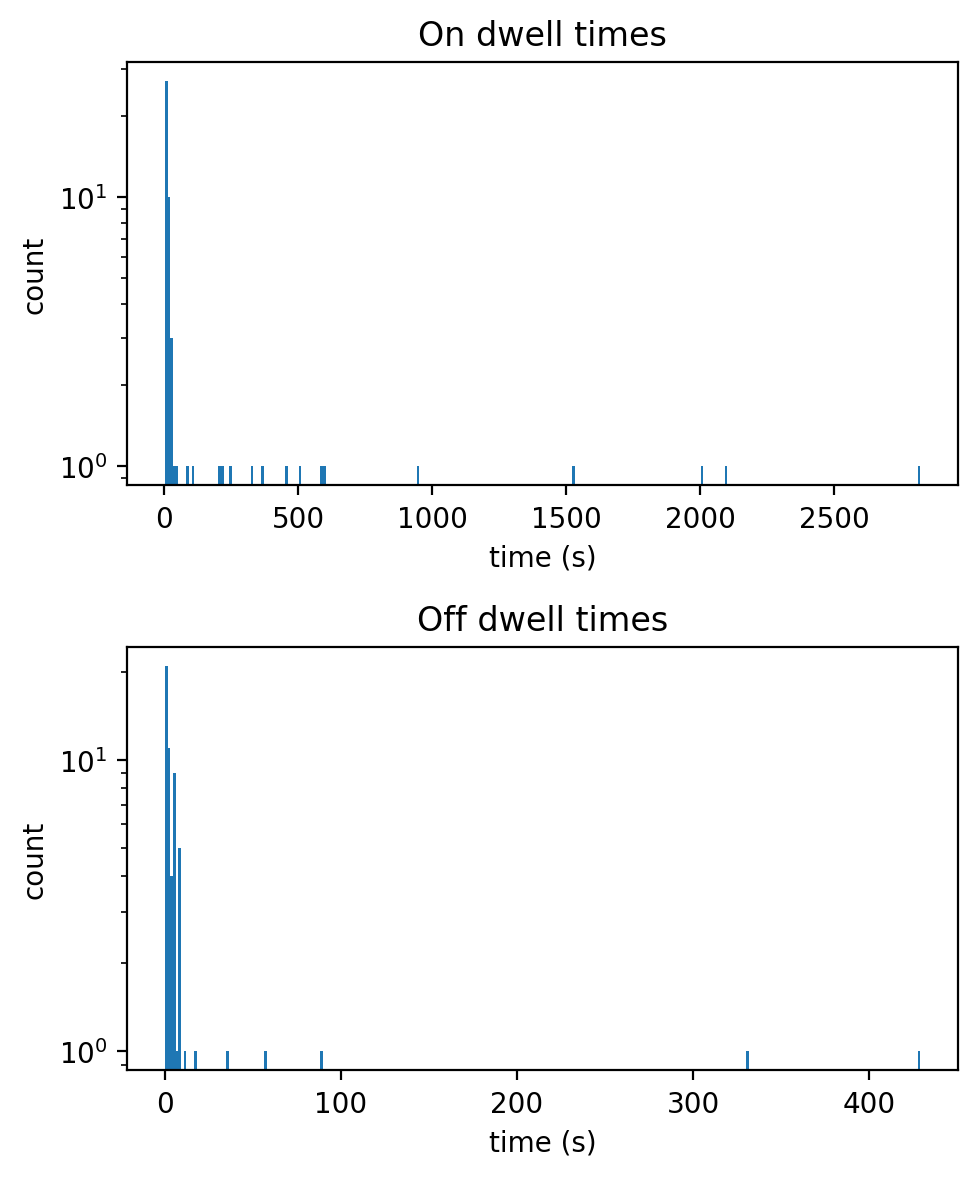

In [10]:
# delete last entry in off dwell times
dwell_times['off'] = dwell_times['off'][:-1]

# set bin width for histogram
bin_width = 10

# calculate number of bins
n_bins = int(dwell_times['off'].max()/ bin_width)



# plot dwell times as histogram in two subplots
fig, ax = plt.subplots(2, 1, figsize=(5, 6))
ax[0].hist(dwell_times['off'], bins=n_bins)
ax[0].set_title('On dwell times')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('count')
ax[1].hist(dwell_times['on'], bins=n_bins)
ax[1].set_title('Off dwell times')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('count')


# Set logaritmic scale for x axis
ax[0].set_yscale('log')
ax[1].set_yscale('log')


plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

In [23]:

# Simulated noisy signal (replace this with your actual signal)
# Assume 'signal' is your input signal as a 1D array
signal = ts_binned.as_dataframe['detector_sum'][:20000]

# Prepare data for LSTM without binarization
def create_sequences(signal, n_steps):
    X, y = [], []
    for i in range(len(signal)):
        end_ix = i + n_steps
        if end_ix > len(signal)-1:
            break
        seq_x, seq_y = signal[i:end_ix], signal[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10  # Define the number of time steps for sequences
X, y = create_sequences(signal, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build LSTM model without binarization
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model.fit(X, y, epochs=20, verbose=0)

# Make predictions on the signal
predicted_states = model.predict(X)

625/625 [==============================] - 0s 644us/step


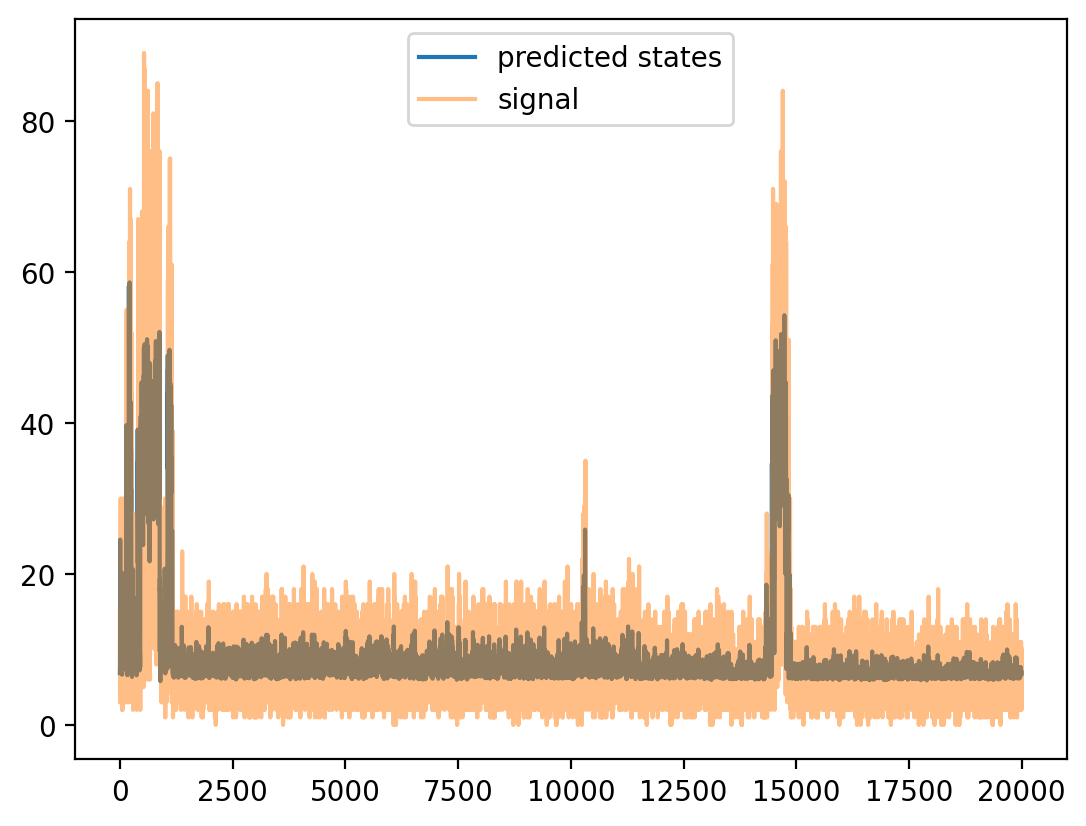

In [24]:
# plot predicted states and signal
plt.plot(predicted_states, label='predicted states')
plt.plot(signal, label='signal', alpha=0.5)
plt.legend()
plt.show()